# Trialing generative processes for chemical microscopy (part 1)

Is it possible to use a generative process to model microscope images (and is it worth the effort)?

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns
from numpyro import deterministic, plate, sample
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam
from PIL import Image

plt.rcParams['figure.dpi'] = 200

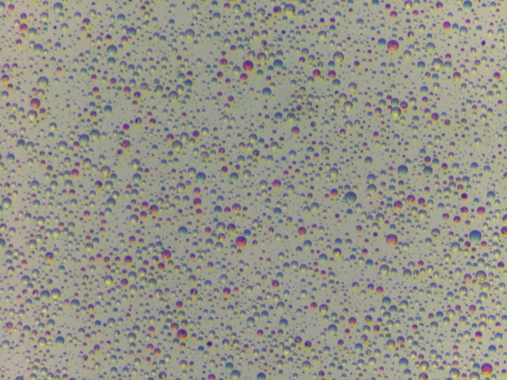

In [2]:
img = Image.open('data/example.jpg')
img = img.resize((img.width // 4, img.height // 4))
img

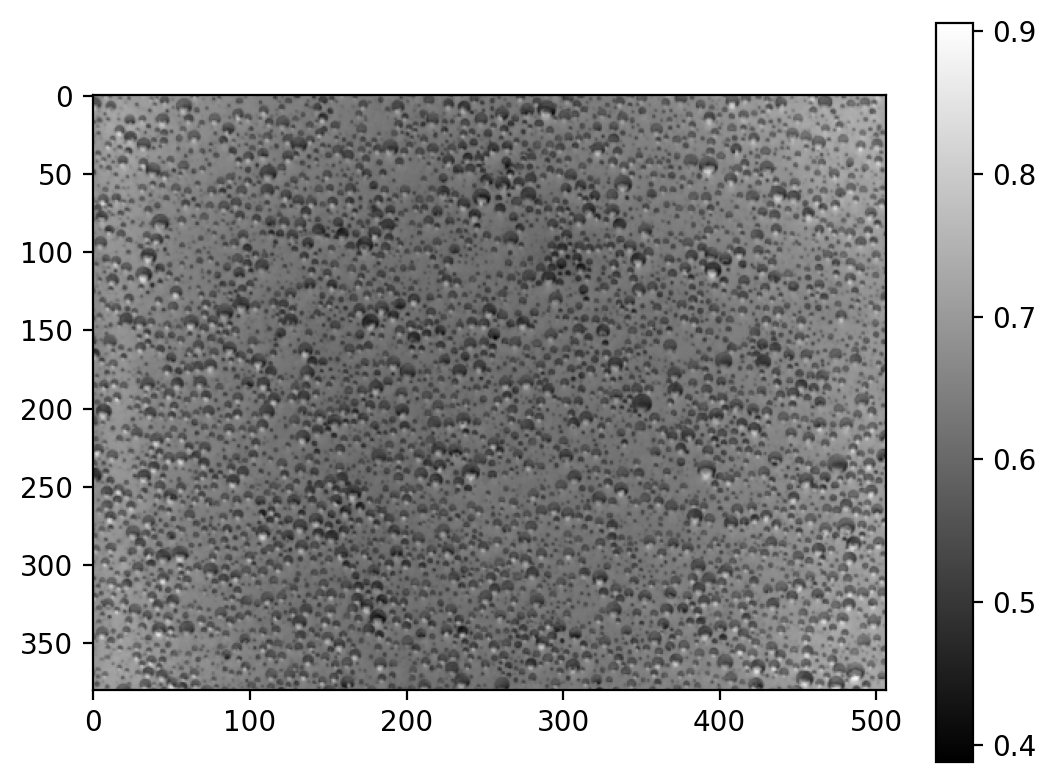

In [3]:
# convert img to HSV space
img_hsv = np.array(img.convert('HSV')) / 255.0

plt.imshow(img_hsv[..., 2], cmap='gray')
plt.colorbar()

In [4]:
def model(w, h, n_droplets, channel, types=10, mask_shape=(15, 15)):
    # Sample droplet locations and sizes
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, 1)) * (w - mask_shape[1] - 1)
        y = sample("y", dist.Uniform(0, 1)) * (h - mask_shape[0] - 1)
        with plate("types", types):
            composition = sample("composition", dist.Uniform(0, 1))
    mask = sample('mask', dist.Uniform(0, 1).expand((types, *mask_shape)))

    # Instead of round, use floor and linear interpolation
    x_floor = jnp.floor(x)
    y_floor = jnp.floor(y)
    x_frac = x - x_floor
    y_frac = y - y_floor

    dx = jnp.arange(mask_shape[1])[:, None, None]
    dy = jnp.arange(mask_shape[0])[None, :, None]

    # Generate coordinates for bilinear interpolation
    x1 = x_floor[None, None, :].astype(int) + dx
    x2 = x1 + 1
    y1 = y_floor[None, None, :].astype(int) + dy
    y2 = y1 + 1

    # Calculate weights for bilinear interpolation
    wx2 = x_frac[None, None, :]
    wx1 = 1 - wx2
    wy2 = y_frac[None, None, :]
    wy1 = 1 - wy2

    # Calculate droplet masks
    droplet_masks = jnp.einsum('tn,thw->hwn', composition, mask)

    # Initialize background
    bg = sample("bg", dist.Uniform(0, 1))
    img = jnp.full((h, w), bg)

    # Add droplets using bilinear interpolation
    img = img.at[y1, x1].add(droplet_masks * (wx1 * wy1))
    img = img.at[y1, x2].add(droplet_masks * (wx2 * wy1))
    img = img.at[y2, x1].add(droplet_masks * (wx1 * wy2))
    img = img.at[y2, x2].add(droplet_masks * (wx2 * wy2))

    img = jnp.clip(img, 0, 1)
    img = deterministic('img', img)
    diff = deterministic('diff', channel - img)
    sample('obs', dist.Normal(scale=0.05), obs=diff)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [07:46<00:00, 42.90it/s, init loss: 18243708.0000, avg. loss [19001-20000]: 1217140.7500]


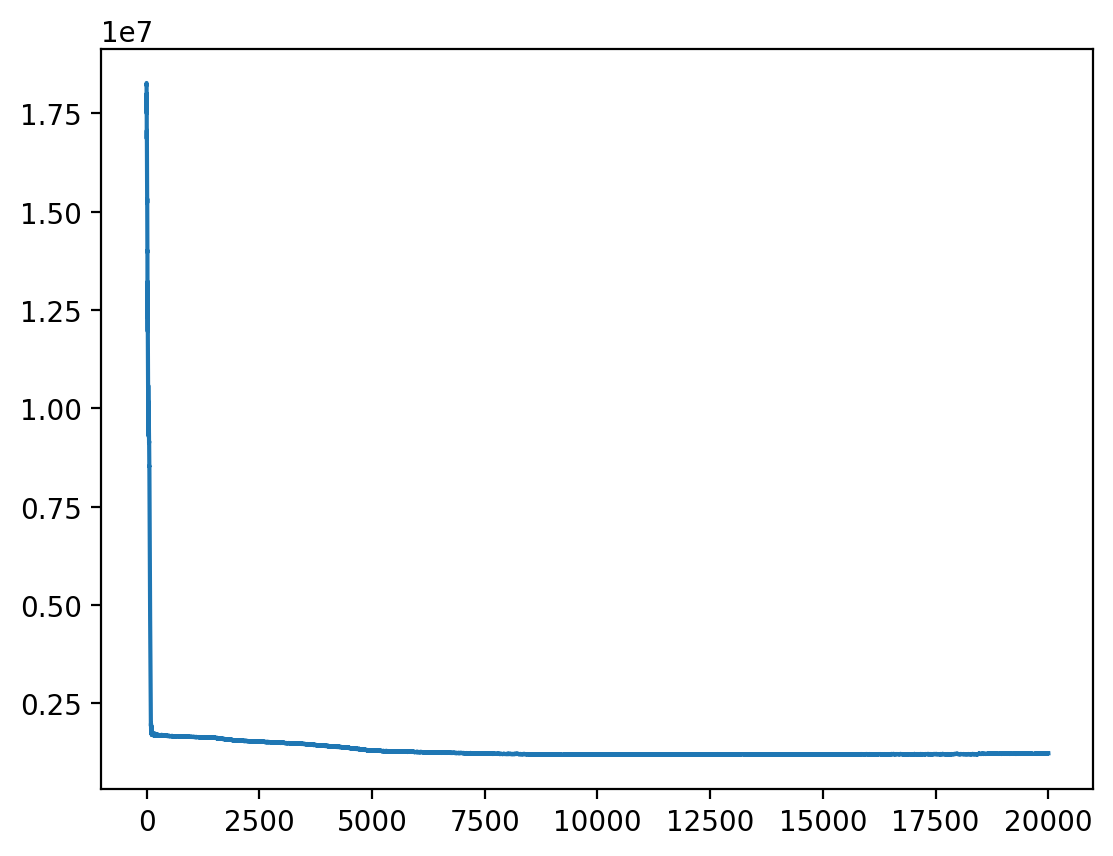

In [25]:
guide = AutoNormal(model)
svi = SVI(model, guide, Adam(0.02), Trace_ELBO())

svi_result = svi.run(jax.random.PRNGKey(0), 20000, img.width, img.height, 2000, img_hsv[..., 0])
samples_svi = guide.sample_posterior(jax.random.PRNGKey(0), svi_result.params, sample_shape=(100,))
plt.plot(svi_result.losses)

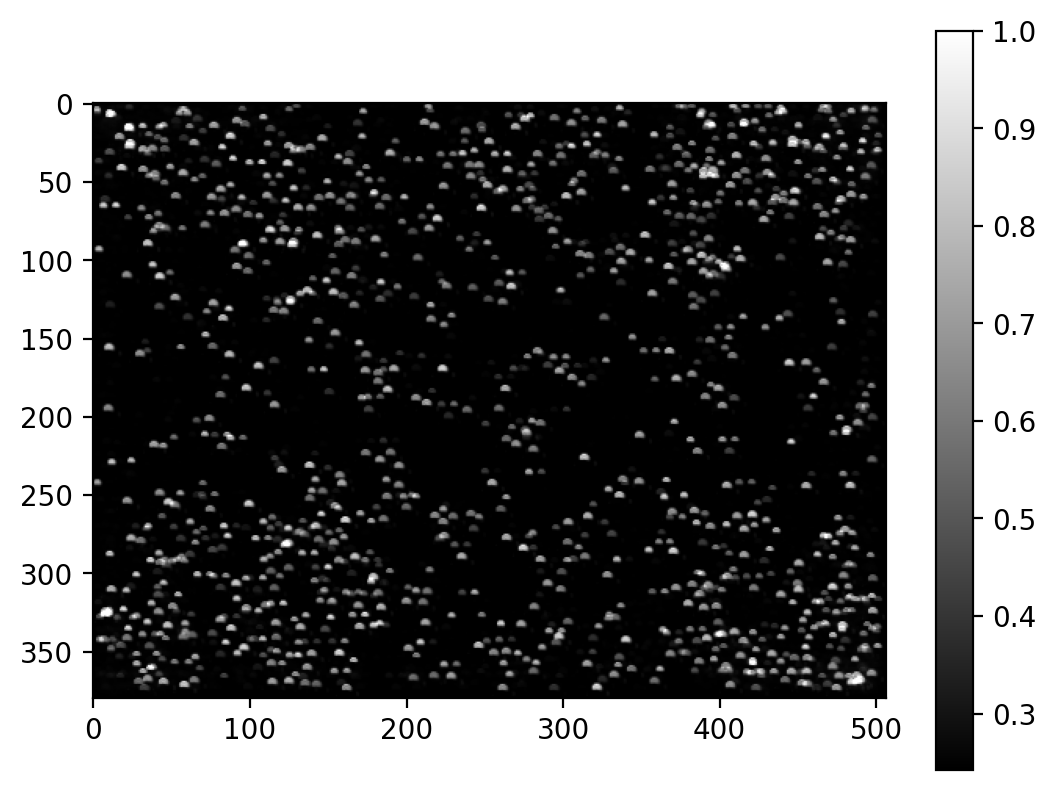

In [26]:
plt.imshow(samples_svi['img'][0], cmap='gray')
plt.colorbar()

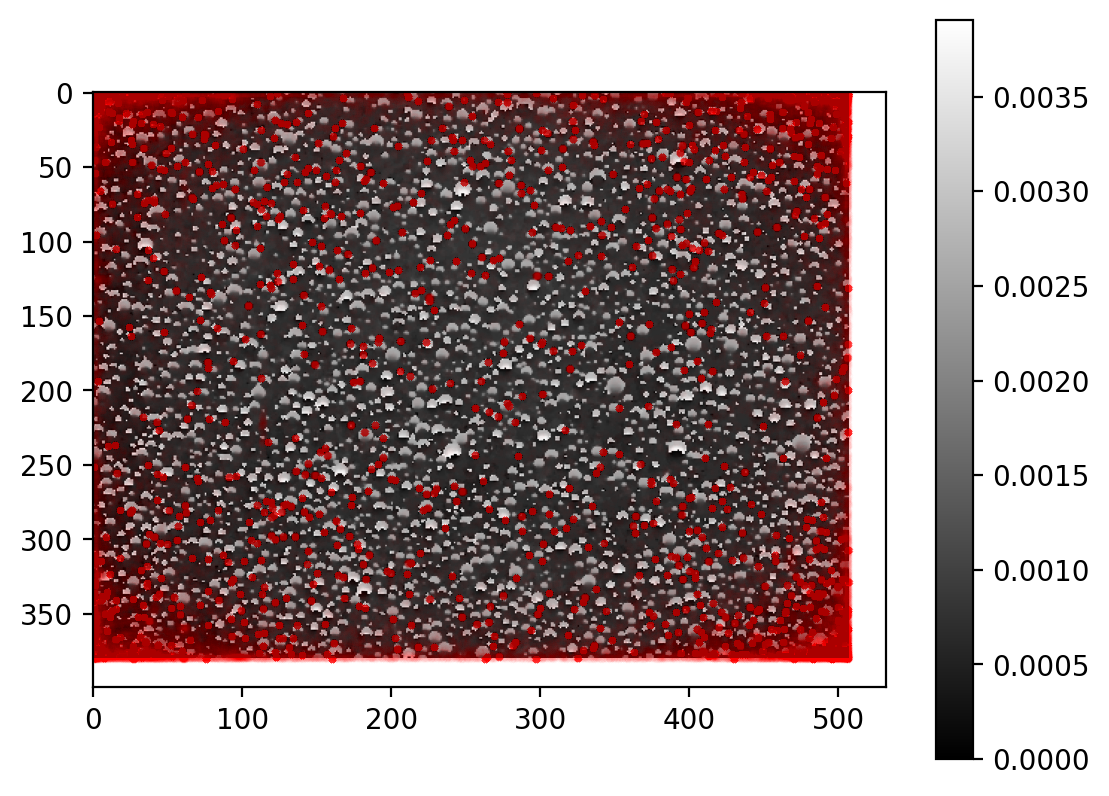

In [27]:
plt.imshow(img_hsv[:, :, 0]/255.0, cmap='gray')
plt.colorbar()
plt.scatter(samples_svi['x'][:100] * img_hsv.shape[1], samples_svi['y'][:100] * img_hsv.shape[0], s=4, alpha=0.01, c='red', marker='x')

In [ ]:
plt.scatter(samples_svi['x'][:100], samples_svi['y'][:100], s=4, alpha=0.01, c='red')

In [ ]:
plt.scatter(samples_svi['x'].mean(axis=0), samples_svi['y'].mean(axis=0), s=4, alpha=0.1, c='red')

In [ ]:
fig, axes = plt.subplots(samples_svi['mask'].shape[1], 1, figsize=(1, samples_svi['mask'].shape[1]), sharex=True)
for i, ax in enumerate(axes):
    ax.imshow(samples_svi['mask'].mean(axis=0)[i], cmap='gray', vmin=0, vmax=1)